In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Epoch 1/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5768 - loss: 0.6750 - val_accuracy: 0.6811 - val_loss: 0.6241
Epoch 2/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7140 - loss: 0.5894 - val_accuracy: 0.7388 - val_loss: 0.5776
Epoch 3/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7519 - loss: 0.5558 - val_accuracy: 0.7548 - val_loss: 0.5475
Epoch 4/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7604 - loss: 0.5407 - val_accuracy: 0.7692 - val_loss: 0.5237
Epoch 5/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7695 - loss: 0.5049 - val_accuracy: 0.7853 - val_loss: 0.5007
Epoch 6/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7853 - loss: 0.4802 - val_accuracy: 0.7853 - val_loss: 0.4833
Epoch 7/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7895 - loss: 0.4729 - val_accuracy: 0.7853 - val_loss: 0.4687
Epoch 8/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8095 - loss: 0.4436 - val_accuracy: 0.7917 - 

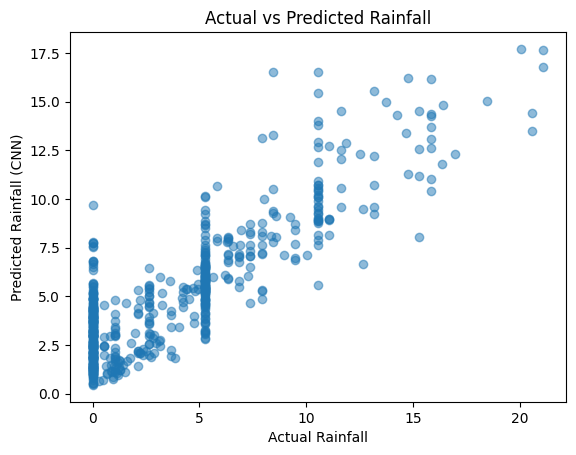

In [ ]:
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-7)) * 100

meses = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN",
         "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
df = pd.read_csv("/content/drive/MyDrive/SIC Proyecto/lluvia(2010-2022).csv")
df = df.melt(id_vars=["PARAMETER", "YEAR", "LAT", "LON"], value_vars=meses, var_name="Mes", value_name="Lluvia")
df.rename(columns={"YEAR": "Año", "LAT": "Latitud", "LON": "Longitud"}, inplace=True)
df.drop("PARAMETER", axis=1, inplace=True)
df["Mes"] = df["Mes"].map({m: i+1 for i, m in enumerate(meses)})
df["Lluvia"] = np.log1p(df["Lluvia"])

X = df[["Latitud", "Longitud", "Año", "Mes"]]
y = df["Lluvia"]
y_class = (y > 0).astype(int)  # 1 si llueve, 0 si no
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(X, y, y_class, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")

# Red de clasificación (para saber si hay lluvia o no)
inputs_class = Input(shape=(X_train.shape[1],))
x_class = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(inputs_class)
x_class = Dense(128, activation='relu')(inputs_class)
x_class = Dense(64, activation='relu')(inputs_class)
x_class = Dropout(0.3)(x_class)
x_class = Dense(32, activation='relu')(x_class)
x_class = Dense(1, activation='sigmoid')(x_class)  # Salida binaria
model_class = Model(inputs_class, x_class)
model_class.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# train 1 model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_class.fit(X_train, y_train_class, epochs=500, batch_size=64, validation_data=(X_test, y_test_class), callbacks=[early_stopping])
y_pred_class = model_class.predict(X_test)

# ajuste para red conv2d
X_train_cnn = X_train.reshape(-1, 2, 2, 1)
X_test_cnn = X_test.reshape(-1, 2, 2, 1)

# Red CNN para predecir la cantidad de lluvia (solo si hay lluvia)
inputs_cnn = Input(shape=(2, 2, 1))
x_cnn = Conv2D(128, (2, 2), activation='relu', padding='same')(inputs_cnn)
x_cnn = Conv2D(64, (2, 2), activation='relu', padding='same')(inputs_cnn)
x_cnn = Flatten()(x_cnn)
x_cnn = Dense(128, activation='relu')(x_cnn)
x_cnn = Dropout(0.3)(x_cnn)
x_cnn = Dense(64, activation='relu')(x_cnn)
x_cnn = Dense(1, activation='linear')(x_cnn)
model_cnn = Model(inputs_cnn, x_cnn)
model_cnn.compile(optimizer=Nadam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenamiento del modelo CNN solo con los datos donde hay lluvia (y_class == 1)
X_train_cnn = X_train_cnn[y_train_class == 1]
y_train_cnn = y_train[y_train_class == 1]

model_cnn.fit(X_train_cnn, y_train_cnn, epochs=500, batch_size=64)
model_cnn.save('./model.keras')
y_pred_cnn = model_cnn.predict(X_test_cnn)

# Evaluar el modelo hybrid
y_test_real = np.expm1(y_test.values.flatten())
y_pred_real_cnn = np.expm1(y_pred_cnn.flatten())

# SMAPE para la predicc de la lluvia
smape_value = smape(y_test_real, y_pred_real_cnn)
print(f"SMAPE: {smape_value}%")
plt.scatter(y_test_real, y_pred_real_cnn, alpha=0.5)
plt.xlabel("Actual Rainfall")
plt.ylabel("Predicted Rainfall (CNN)")
plt.title("Actual vs Predicted Rainfall")
plt.show()

In [ ]:
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-7)) * 10

y_test_real = np.expm1(y_test.values.flatten())
y_pred_real = np.expm1(y_pred_cnn.flatten())

mse_val = mean_squared_error(y_test_real, y_pred_real)
mae_val = mean_absolute_error(y_test_real, y_pred_real)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_test_real, y_pred_real)
smape_val = smape(y_test_real, y_pred_real)

print("Metricas en el conjunto de test:")
print("MSE:", mse_val)
print("MAE:", mae_val)
print("RMSE:", rmse_val)
print("R²:", r2_val)
print("SMAPE:", smape_val, "%")


Metricas en el conjunto de test:
MSE: 5.751808916959546
MAE: 1.8898860855725332
RMSE: 2.398292917255844
R²: 0.7104674729075646
SMAPE: 9.61101086919913 %


In [ ]:

train_loss_class, train_acc_class = model_class.evaluate(X_train, y_train_class, verbose=0)
test_loss_class, test_acc_class = model_class.evaluate(X_test, y_test_class, verbose=0)
print("Clasificación - Train Accuracy:", train_acc_class)
print("Clasificación - Test Accuracy:", test_acc_class)

train_rain_indices = y_train_class == 1
test_rain_indices = y_test_class == 1

X_train_rain = X_train[train_rain_indices]
y_train_rain = y_train[train_rain_indices]
X_test_rain = X_test[test_rain_indices]
y_test_rain = y_test[test_rain_indices]

# Reestructura de datos para la CNN: de (n, 4) a (n, 2, 2, 1)
X_train_rain_cnn = X_train_rain.reshape(-1, 2, 2, 1)
X_test_rain_cnn = X_test_rain.reshape(-1, 2, 2, 1)

y_pred_train_cnn = model_cnn.predict(X_train_rain_cnn)
y_pred_test_cnn = model_cnn.predict(X_test_rain_cnn)
y_train_rain_real = np.expm1(y_train_rain)
y_test_rain_real = np.expm1(y_test_rain)
y_pred_train_real = np.expm1(y_pred_train_cnn.flatten())
y_pred_test_real = np.expm1(y_pred_test_cnn.flatten())

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-7)) * 100

mse_train = mean_squared_error(y_train_rain_real, y_pred_train_real)
mae_train = mean_absolute_error(y_train_rain_real, y_pred_train_real)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_rain_real, y_pred_train_real)
smape_train = smape(y_train_rain_real, y_pred_train_real)

mse_test = mean_squared_error(y_test_rain_real, y_pred_test_real)
mae_test = mean_absolute_error(y_test_rain_real, y_pred_test_real)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_rain_real, y_pred_test_real)
smape_test = smape(y_test_rain_real, y_pred_test_real)

print("Metricas del (CNN) - Conjunto de Entrenamiento:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)
print("R²:", r2_train)
print("SMAPE:", smape_train, "%\n")

print("Metricas del (CNN) - Conjunto de Prueba:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)
print("R²:", r2_test)
print("SMAPE:", smape_test, "%")

Clasificación - Train Accuracy: 0.9090544581413269
Clasificación - Test Accuracy: 0.8717948794364929
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Metricas del (CNN) - Conjunto de Entrenamiento:
MSE: 2.147756530196611
MAE: 0.9865468378445036
RMSE: 1.4655226133351238
R²: 0.8657352467998641
SMAPE: 19.155906507476768 %

Metricas del (CNN) - Conjunto de Prueba:
MSE: 3.8343944890899437
MAE: 1.4229892310119692
RMSE: 1.9581609967236973
R²: 0.7813329472137953
SMAPE: 27.586995891122257 %


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Matrix - Train:
[[ 828   66]
 [ 161 1441]]

Matrix - Test:
[[224  24]
 [ 56 320]]


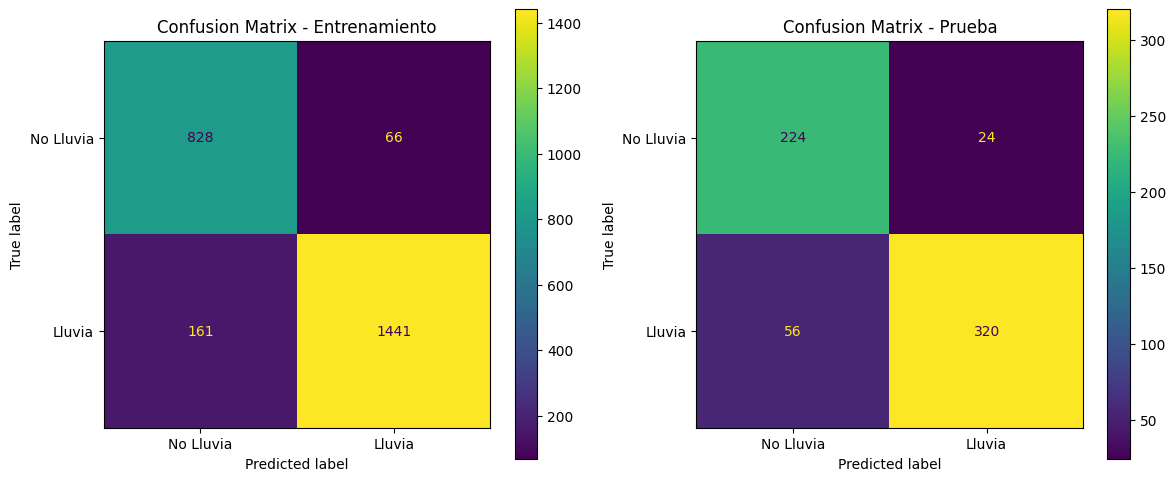

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_train_class = (model_class.predict(X_train) > 0.5).astype("int32")
y_pred_test_class = (model_class.predict(X_test) > 0.5).astype("int32")
cm_train = confusion_matrix(y_train_class, y_pred_train_class)
print("Matrix - Train:")
print(cm_train)

cm_test = confusion_matrix(y_test_class, y_pred_test_class)
print("\nMatrix - Test:")
print(cm_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_train, display_labels=["No Lluvia", "Lluvia"]).plot(ax=ax[0])
ax[0].set_title("Confusion Matrix - Entrenamiento")
ConfusionMatrixDisplay(cm_test, display_labels=["No Lluvia", "Lluvia"]).plot(ax=ax[1])
ax[1].set_title("Confusion Matrix - Prueba")
plt.tight_layout()
plt.show()
